# Distribution histograms and individual benchmarks

In [1]:
%matplotlib notebook

This notebook mainly serves to extract data used for the Archer eCSE report.

Set the number of OpenMP threads to use. Note that the number of threads is fixed at import time of DCPROGS so you will need to change restart the notebook and reexecute from the begining for any changes to take effect.

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.text as mtext

In [4]:
import time
import math
import sys
import numpy as np
from scipy.optimize import minimize

from dcpyps import dcio
from dcpyps import dataset
from dcpyps import mechanism
from dcprogs.likelihood import Log10Likelihood

# LOAD DATA: Burzomato 2004 example set.
scnfiles = [["./samples/glydemo/A-10.scn"], 
            ["./samples/glydemo/B-30.scn"],
            ["./samples/glydemo/C-100.scn"], 
            ["./samples/glydemo/D-1000.scn"]]
tres = [0.000030, 0.000030, 0.000030, 0.000030]
tcrit = [0.004, -1, -0.06, -0.02]
conc = [10e-6, 30e-6, 100e-6, 1000e-6]

recs = []
bursts = []
for i in range(len(scnfiles)):
    rec = dataset.SCRecord(scnfiles[i], conc[i], tres[i], tcrit[i])
    rec.record_type = 'recorded'
    recs.append(rec)
    bursts.append(rec.bursts.intervals())

In [5]:
n_experiments = len(recs)
openings = []
opening_dists = []
n_bursts = np.empty(4)
for i,rec in enumerate(recs):
    n_bursts[i] = rec.bursts.count()
    openings = np.zeros(rec.bursts.count())
    for i,burst in enumerate(rec.bursts.all()):
        openings[i] = burst.get_openings_number()
    opening_dists.append(openings)

Plot the distribution of bursts within the 4 different experiments showing how number of bursts corelate with the lenght of the bursts.

<IPython.core.display.Javascript object>


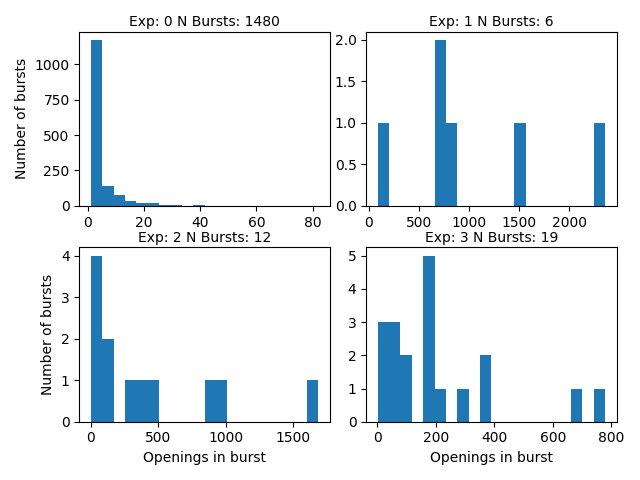

In [161]:
fig, ax = plt.subplots(2,2)
ax = ax.flatten()
for i in range(n_experiments):
    ax[i].hist(opening_dists[i], bins=20)
    ax[i].set_title("Exp: {} N Bursts: {}".format(i, int(n_bursts[i])), fontsize=10)
ylabel = ax[0].set_ylabel('Number of bursts')
ylabel = ax[2].set_ylabel('Number of bursts')
xlabel = ax[2].set_xlabel('Openings in burst')
xlabel = ax[3].set_xlabel('Openings in burst')
fig.tight_layout(w_pad=0.1, h_pad=0.1)

In [7]:
# LOAD FLIP MECHANISM USED Burzomato et al 2004
mecfn = "../../DCPYPS/dcpyps/samples/mec/demomec.mec"
version, meclist, max_mecnum = dcio.mec_get_list(mecfn)
mec = dcio.mec_load(mecfn, meclist[2][0])

# PREPARE RATE CONSTANTS.
rates = [4500.0, 700.0, 2500.0, 1800.0, 900.0, 18000.0, 200.0, 0.1100E+06, 4900.0, 0.4000E+09, 1850.0, 10000.0, 5000.0, 0.7500E+09, 8500.0, 1050.0, 3500.0, 0.5000E+07, 2300.0, 0.9500E+07, 1950, 0.130000E+08]

mec.set_rateconstants(rates)

# Fixed rates.
#fixed = np.array([False, False, False, False, False, False, False, True,
#    False, False, False, False, False, False])
#if fixed.size == len(mec.Rates):
for i in range(len(mec.Rates)):
    mec.Rates[i].fixed = False

# Constrained rates.
mec.Rates[21].is_constrained = True
mec.Rates[21].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[21].constrain_args = [17, 3]
mec.Rates[19].is_constrained = True
mec.Rates[19].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[19].constrain_args = [17, 2]
mec.Rates[16].is_constrained = True
mec.Rates[16].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[16].constrain_args = [20, 3]
mec.Rates[18].is_constrained = True
mec.Rates[18].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[18].constrain_args = [20, 2]
mec.Rates[8].is_constrained = True
mec.Rates[8].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[8].constrain_args = [12, 1.5]
mec.Rates[13].is_constrained = True
mec.Rates[13].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[13].constrain_args = [9, 2]
mec.update_constrains()

mec.set_mr(True, 7, 0)
mec.set_mr(True, 15, 1)

mec.printout(sys.stdout)
theta = np.log(mec.theta())

kwargs = {'nmax': 2, 'xtol': 1e-12, 'rtol': 1e-12, 'itermax': 100,
    'lower_bound': -1e6, 'upper_bound': 0}
likelihood = []

for i in range(len(recs)):
    likelihood.append(Log10Likelihood(bursts[i], mec.kA,
        recs[i].tres, recs[i].tcrit, **kwargs))

def dcprogslik(x, args=None):
    mec.theta_unsqueeze(np.exp(x))
    lik = 0
    for i in range(len(conc)):
        mec.set_eff('c', conc[i])
        lik += -likelihood[i](mec.Q) * math.log(10)
    return lik


class dcpyps.Mechanism
Values of unit rates [1/sec]:
0	From AF*  	to AF    	alpha1       	4500.0
1	From AF  	to AF*    	beta1        	700.0
2	From A2F*  	to A2F    	alpha2       	2500.0
3	From A2F  	to A2F*    	beta2        	1800.0
4	From A3F*  	to A3F    	alpha3       	900.0
5	From A3F  	to A3F*    	beta3        	18000.0
6	From A3F  	to A3R    	gama3        	200.0
7	From A3R  	to A3F    	delta3       	67459.4594595
8	From A3F  	to A2F    	3kf(-3)      	7500.0
9	From A2F  	to A3F    	kf(+3)       	400000000.0
10	From A2F  	to A2R    	gama2        	1850.0
11	From A2R  	to A2F    	delta2       	10000.0
12	From A2F  	to AF    	2kf(-2)      	5000.0
13	From AF  	to A2F    	2kf(+2)      	800000000.0
14	From AF  	to AR    	gama1        	8500.0
15	From AR  	to AF    	delta1       	736.313236313
16	From A3R  	to A2R    	3k(-3)       	5850
17	From A2R  	to A3R    	k(+3)        	5000000.0
18	From A2R  	to AR    	2k(-2)       	3900
19	From AR  	to A2R    	2k(+2)       	10000000.0
20	From AR  	to 

In [8]:
%%timeit
dcprogslik(theta)

10 loops, best of 3: 22.9 ms per loop


In [9]:
%%timeit
i = 0
mec.set_eff('c', conc[i])
lik = -likelihood[i](mec.Q) * math.log(10)

100 loops, best of 3: 5.9 ms per loop


In [10]:
%%timeit
i = 1
mec.set_eff('c', conc[i])
lik = -likelihood[i](mec.Q) * math.log(10)

100 loops, best of 3: 6.66 ms per loop


In [11]:
%%timeit
i = 2
mec.set_eff('c', conc[i])
lik = -likelihood[i](mec.Q) * math.log(10)

100 loops, best of 3: 5.8 ms per loop


In [12]:
%%timeit
i = 3
mec.set_eff('c', conc[i])
lik = -likelihood[i](mec.Q) * math.log(10)

100 loops, best of 3: 4.69 ms per loop
